# Data Visualization

## Objectives

*   Business requirement 1: 
    * The client is interested to have a study which will visually differentiate between a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between healthy cherry leaves and cherry leaves with powdery mildew.
* Generate code that answers the business requirement 1 and will be used to build an image montage on the Streamlit dashboard.

## Additional Comments

* No additional comments here. 


---

# Set The Data Directory

## Import libraries

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [17]:
cwd= os.getcwd()

In [18]:
os.chdir('/workspace/pp5-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [19]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection-in-cherry-leaves'

## Set input directories

Sets the train, test and validation paths

In [20]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [21]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

The old version is already available, please create a new version.


### Set label names

In [22]:
# Set the image labels
labels = os.listdir(train_path)
print('The label for the images are:', labels)

The label for the images are: ['healthy', 'powdery_mildew']


---

# Visual representation of image data

## Image shape 

Computes the average image size on the train set.

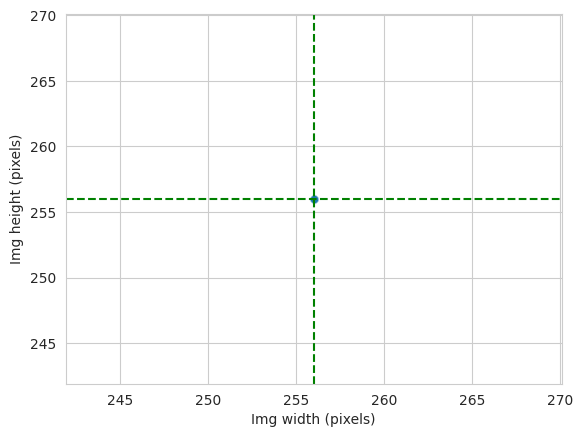

Img width average: 256 
Img height average: 256


In [31]:
dim1, dim2 = [], []
for label in labels:
    for img_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + img_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # the image height
        dim2.append(d2)  # the image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Img width (pixels)")
axes.set_ylabel("Img height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='g', linestyle='--')
axes.axhline(y=dim2_mean, color='g', linestyle='--')
plt.show()
print(f"Img width average: {dim2_mean} \nImg height average: {dim1_mean}")

Bar plot to confirm the average image size on the train set.

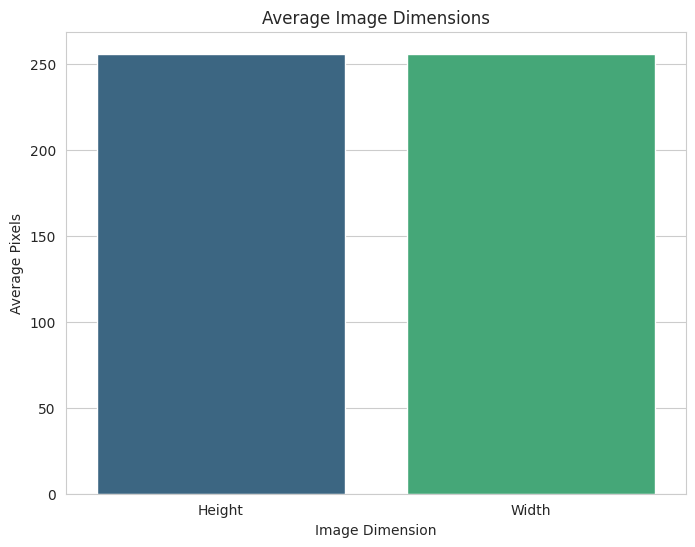

Img width average: 256 
Img height average: 256


In [25]:
# Calculate the mean dimensions
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())

# Prepare data for the bar plot
dimensions = ['Height', 'Width']
mean_values = [dim1_mean, dim2_mean]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot
sns.barplot(x=dimensions, y=mean_values, palette='viridis', ax=ax)
ax.set_xlabel("Image Dimension")
ax.set_ylabel("Average Pixels")
ax.set_title("Average Image Dimensions")

plt.show()
print(f"Img width average: {dim2_mean} \nImg height average: {dim1_mean}")

The size of the images used for training the model is the average dimensions of all images in the training set.

In [32]:
img_shape = (dim1_mean, dim2_mean, 3)
img_shape

(256, 256, 3)

Save the image shape embeddings for further processing

In [33]:
joblib.dump(value=img_shape ,
            filename=f"{file_path}/img_shape.pkl")

['outputs/v1/img_shape.pkl']

## Average and variability of the images per label

### Function to load images into an array (tensor).

In [34]:
from tensorflow.keras.preprocessing import image

def load_img_as_tensor(my_data_dir, new_size=(50, 50), nr_imgs_per_label=25):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for img_filename in os.listdir(my_data_dir + '/' + label):
            # nr_imgs_per_label: we set a limit, since it may take too much time
            if counter < nr_imgs_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + img_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load image shapes and labels into an array

In [35]:
X, y = load_img_as_tensor(my_data_dir=train_path,
                           new_size=img_shape,
                           nr_imgs_per_label=30)
print(X.shape, y.shape)


(60, 256, 256, 3) (60,)


### Plot and save the mean and variability of the images per label

In [38]:
def plot_avg_variance_per_label(X, y, figsize=(12, 5), save_img=False):
    """
    The algorithmic description for the function is:
    * To loop over all of the labels
    * Subset an array based on a specified label
    * Calculate the average (mean) and standard deviation
    * Generate a visual representation illustrating the average and variance of images
    * Save the image
    """

    for displayed_label in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == displayed_label, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label for {displayed_label} leaves ====")
        print(f"The image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {displayed_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {displayed_label}")
        axes[1].imshow(std_img, cmap='gray')

        if save_img:
            plt.savefig(f"{file_path}/avg_var_{displayed_label}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label for healthy leaves ====
The image Shape: (256, 256, 3)
==== Label for powdery_mildew leaves ====
The image Shape: (256, 256, 3)


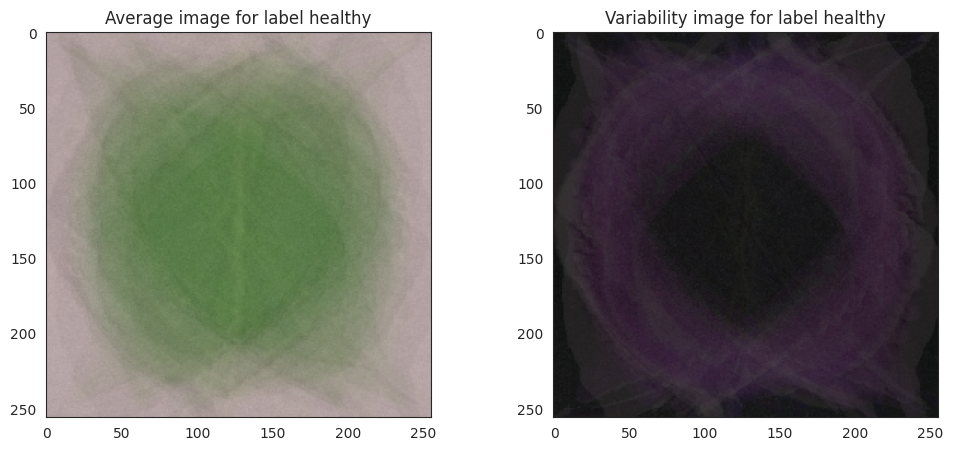

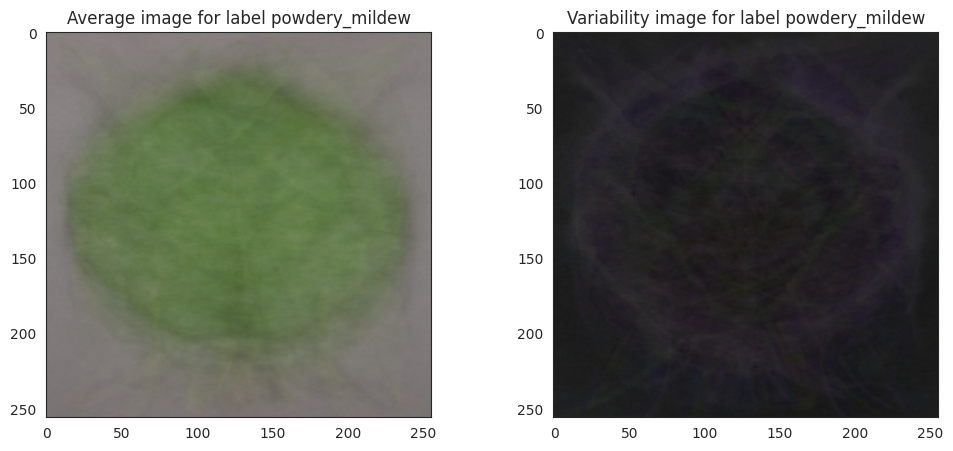

In [39]:
plot_avg_variance_per_label(X=X, y=y, figsize=(12, 5), save_img=True)
